<a href="https://colab.research.google.com/github/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 - New Cases, Deaths, Death Rate, Reproduction Number (R), 7 Day Incidence

The code downloads data from Johns Hopkins CSSE: https://github.com/CSSEGISandData and population data from [The World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL)

To run the code in Google Colab either select **'Runtime' -> 'Run All'** from the main menu

or

press **CTRL+F9** (Windows/Linux) / **⌘+F9** (Mac)


## Download Data

In [11]:
#@title

# Copyright (C) 2020, 2021 Oliver Maerz
# 
# This program is free software: you can redistribute it and/or modify it under 
# the terms of the GNU General Public License version 3 (GPLv3) as published by 
# the Free Software Foundation.
#
# This program is distributed in the hope that it will be useful, but WITHOUT 
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# License URL: https://github.com/OliverMaerz/Covid-19/blob/master/LICENSE
# Source: https://github.com/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import locale

# Display all rows
pd.set_option('display.max_rows', None)

# Set the local for the number formatting
locale.setlocale(locale.LC_ALL, '') 

print("Downloading data from Johns Hopkins CSSE and Worldbank ... \n")

# Download the Johns Hopkins CSSE global dataset for Covid-19
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
# !curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
# Download population numbers from Wordbank and unzip it
!curl -o population.zip http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
!unzip -o population.zip
!mv API_SP.POP.TOTL_DS2_en_csv*.csv population.csv

# Load the downloaded dataset (csv files) into Pandas dataframes
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, 
                           error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, 
                        error_bad_lines=False)
# recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, 
#                              error_bad_lines=False)
pop_df = pd.read_csv('population.csv', sep=',', header=2,
                     error_bad_lines=False)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  608k  100  608k    0     0  6404k      0 --:--:-- --:--:-- --:--:-- 6404k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  421k  100  421k    0     0  4174k      0 --:--:-- --:--:-- --:--:-- 4174k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80069  100 80069    0     0  87126      0 --:--:-- --:--:-- --:--:-- 87031
Archive:  population.zip
  inflating: Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_2252106.csv  
  inflating: API_SP.POP.TOTL_DS2_en_csv_v2_2252106.csv  
  inflating: Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_2252106.csv  


In [12]:
# To get a list of available countries uncomment the line below and run this cell (with Shift+Enter)
#print(confirmed_df['Country/Region'].drop_duplicates())

Configuration options


In [13]:
# To get the full list of available countries see the cell above
selected_countries = ['Argentina', 'India', 'US', 'Brazil']
days_rolling_average = 7
per_x_population = 1000000

## Helper Functions

In [14]:
#@title

matplotlib.rcParams['figure.figsize'] = [25, 15]

# create the dataframe with the population numbers
pop_df = pop_df[['Country Name','2019']]
pop_df.columns = ['Country','Population']
pop_df.set_index('Country', inplace=True)
pop_df = pop_df.rename(index={'United States':'US'})
pop_df = pop_df.loc[pop_df.index.isin(selected_countries)].copy()
pop_df = pop_df.Population
# Define helper functions


# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & \
                         df['Province/State'].isnull()].copy()

    selected_df.rename(columns={'Country/Region':'Country'}, inplace=True)
    selected_df.set_index('Country', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df


# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    # get rid of negative values (uncomment if processing recover patients)
    #diff_df[diff_df < 0] = 0
    return diff_df
    

# Calculate the cases per x population 
def calculate_cases_per_x_population(df):
    selected_df = get_selected_countries(df)
    # get difference between days (= new cases) total
    diff_df = get_difference_between_days(selected_df)

    # calculate the new cases divided by population 
    # multiplied by per_x_population (e.g. 1000000)
    per_x_pop_df = diff_df.div(pop_df, axis=0) * per_x_population
    return per_x_pop_df


# Plot the graph 
def plot_curve(df, title):
    title = (title + ' per '+ f'{per_x_population:n}' + ' population ('
             + str(days_rolling_average) + ' day rolling average)')
    df_rolling = df.transpose().rolling(window=days_rolling_average).mean()
    df_rolling.plot(kind='line', title=title,logy=False)



## New Daily Cases

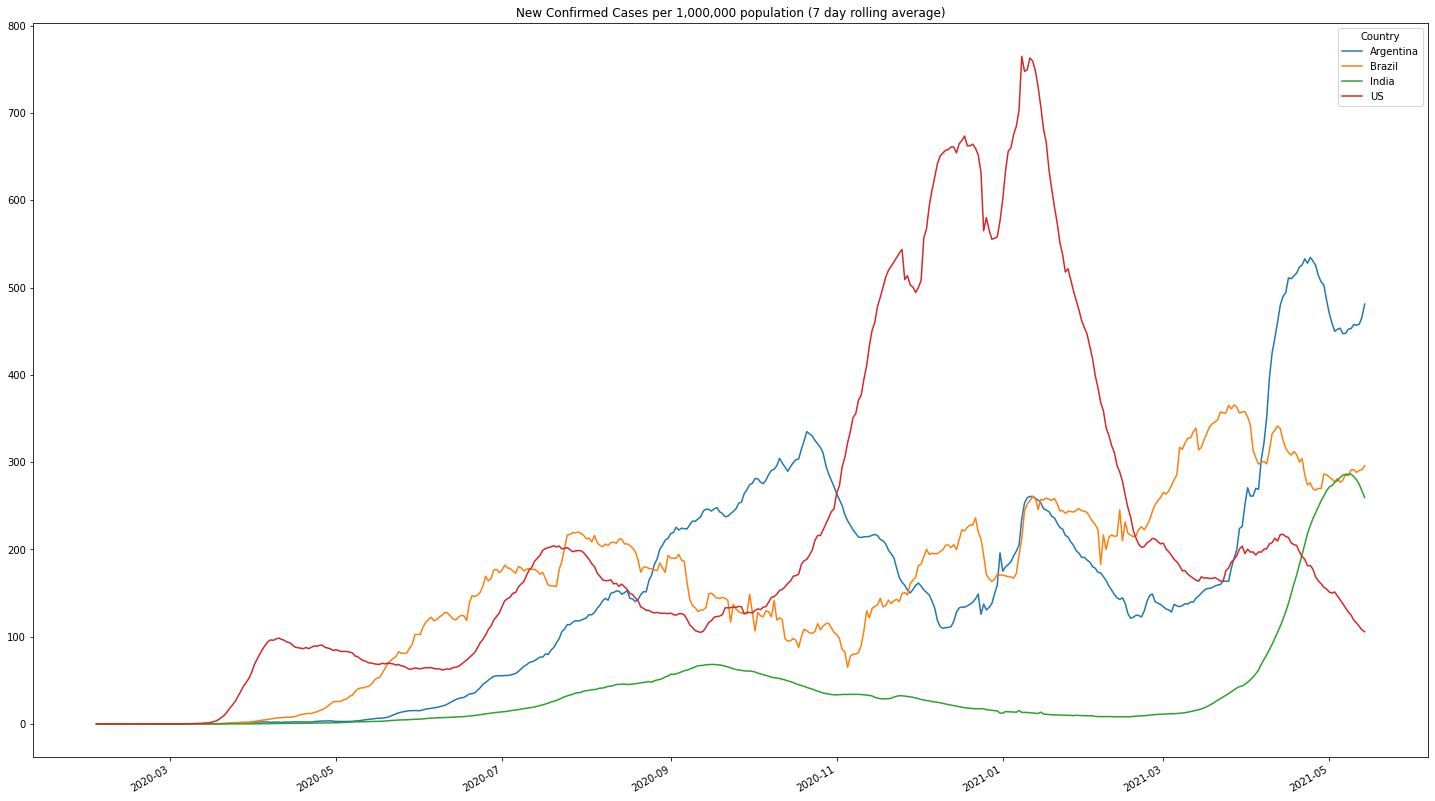

In [15]:
#@title
new_confirmed_df = calculate_cases_per_x_population(confirmed_df)
plot_curve(new_confirmed_df, 'New Confirmed Cases')

## Deaths




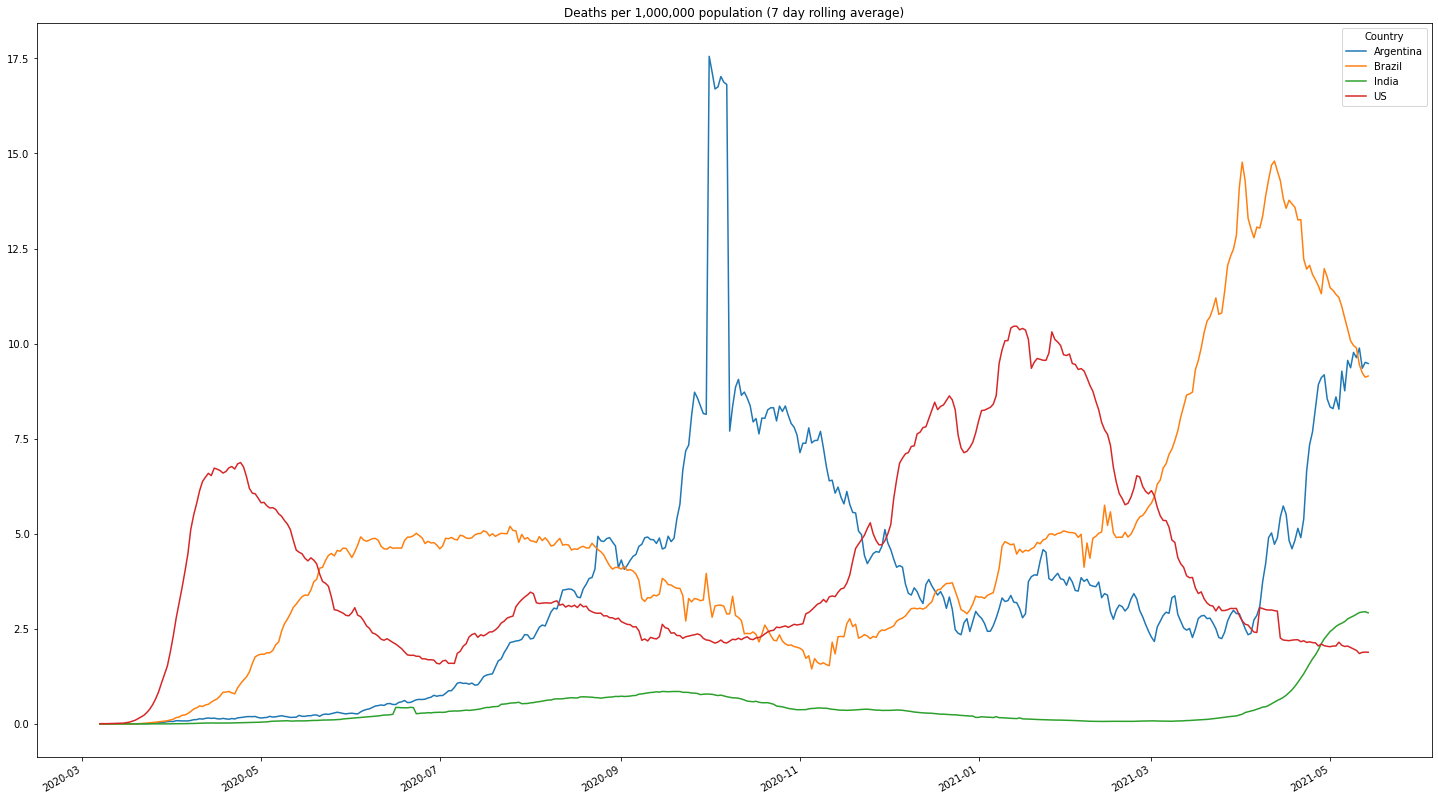

In [16]:
#@title
xdeaths_df =  calculate_cases_per_x_population(deaths_df)
plot_curve(xdeaths_df, 'Deaths')

## Fatality rate

In [17]:
#@title

selected_deaths_df = get_selected_countries(deaths_df)
selected_confirmed_df = get_selected_countries(confirmed_df)

death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country
Argentina    0.021365
Brazil       0.027876
India        0.010922
US           0.017791
Name: 2021-05-14 00:00:00, dtype: float64

## Reproduction number 
Last seven days vs. prior seven days 

In [18]:
#@title

new_confirmed_df = get_difference_between_days(selected_confirmed_df)

# divide new cases from last seven days with new cases from prior seven days
reproduction_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4] \
                   + new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7]) \
                   / (new_confirmed_df.iloc[:,-8] \
                   + new_confirmed_df.iloc[:,-9] \
                   + new_confirmed_df.iloc[:,-10] \
                   + new_confirmed_df.iloc[:,-11] \
                   + new_confirmed_df.iloc[:,-12] \
                   + new_confirmed_df.iloc[:,-13] \
                   + new_confirmed_df.iloc[:,-14])

reproduction_df

Country
Argentina    1.075023
Brazil       1.032208
India        0.909273
US           0.794423
dtype: float64

## 7 Day Incidence 



In [19]:
#@title

new_confirmed_df = get_difference_between_days(selected_confirmed_df)

# divide new cases from last seven days
incidence_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4] \
                   + new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7]) \
                   / pop_df * 100000

incidence_df.round(decimals=0).astype(int)

Country
Argentina    337
Brazil       207
India        182
US            74
dtype: int64

## Display the number of new confirmed cases for the last 8 days

In [20]:
#@title

new_confirmed_df = get_difference_between_days(selected_confirmed_df)

new_confirmed_df.iloc[:,-8:]

,2021-05-07,2021-05-08,2021-05-09,2021-05-10,2021-05-11,2021-05-12,2021-05-13,2021-05-14
Country,,,,,,,,
Argentina,22552.0,18024.0,11582.0,17381.0,25976.0,24475.0,26531.0,27363.0
Brazil,78886.0,63430.0,38911.0,25200.0,72715.0,76692.0,74592.0,85536.0
India,401078.0,403405.0,366494.0,329942.0,348421.0,362727.0,343144.0,326098.0
US,47289.0,34493.0,21392.0,36898.0,33651.0,35878.0,38087.0,42298.0


> Copyright &copy; 2020, 2021 Oliver Maerz - [License](https://github.com/OliverMaerz/Covid-19/blob/master/LICENSE)



